# Sound Classification Training

This notebook creates the Sound Network Architecture and trains it for grasp testset1. After training the network weights will be stored in the folder `./dataset/grasp_60Freq_50TimePerSec_testset1_logs`

In [1]:
import pickle, os, csv, time, shutil
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

In [2]:
def print_image(image, title):
    """Print the image

    :param image: image pixels in list
    :param title: title as string to be printed on top of the image
    """
    plt.imshow(image)
    plt.title(title)
    plt.colorbar()
    plt.show()

def time_taken(start, end):
    """Human readable time between `start` and `end`

    :param start: time.time()
    :param end: time.time()
    :returns: day:hour:minute:second
    """
    time = end-start
    day = time // (24 * 3600)
    time = time % (24 * 3600)
    hour = time // 3600
    time %= 3600
    minutes = time // 60
    time %= 60
    seconds = time
    day_hour_min_sec = str('%02d' % int(day))+":"+str('%02d' % int(hour))+":"+str('%02d' % int(minutes))+":"+str('%02d' % int(seconds))
    
    return day_hour_min_sec

In [3]:
# gdd.download_file_from_google_drive(file_id='15xPAbso4-uLk8PcRi9cb70r1r3FaU6ux', dest_path='../Deep-Multi-Sensory-Object-Categorization_dataset/category_object_labels.bin',unzip=False)
bin_file = open("./dataset/category_object_labels.bin", "rb")
category_labels = pickle.load(bin_file)
object_labels = pickle.load(bin_file)
bin_file.close()

## Sound Dataset

In [4]:
"""
Downloading testset1 for sound of grasp interaction and reading it.
"""

db_file_name = "grasp_60Freq_50TimePerSec_testset1.bin"
gdd.download_file_from_google_drive(file_id='1WChpWIY53Ww1Z7NWjJ1YfQOim5goMD9N',
                                    dest_path='./dataset/'+db_file_name,
                                    unzip=False)

bin_file = open("./dataset/"+db_file_name, "rb")

audio_frames_2d_train = pickle.load(bin_file)
category_label_train = pickle.load(bin_file)
object_label_train = pickle.load(bin_file)
category_label_train_one_hot = pickle.load(bin_file)
object_label_train_one_hot = pickle.load(bin_file)

audio_frames_2d_test = pickle.load(bin_file)
category_label_test = pickle.load(bin_file)
object_label_test = pickle.load(bin_file)
category_label_test_one_hot = pickle.load(bin_file)
object_label_test_one_hot = pickle.load(bin_file)

bin_file.close()

batch, frames, freq, channel: (400, 100, 60, 2)


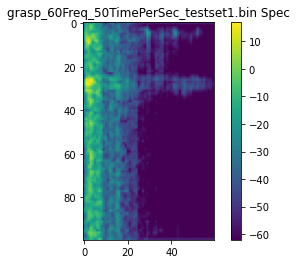

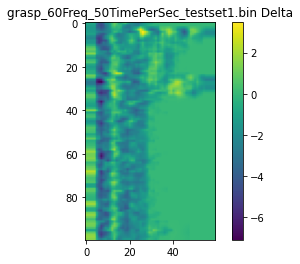

Category:  egg
Object:  egg_rough_styrofoam


In [5]:
"""
Display a frame of the sound dataset
"""

batch_no = 188
print("batch, frames, freq, channel:", audio_frames_2d_train.shape)
print_image(audio_frames_2d_train[batch_no, :, :, 0], db_file_name+" Spec")
print_image(audio_frames_2d_train[batch_no, :, :, 1], db_file_name+" Delta")
print("Category: ", list(category_labels.keys())[list(category_labels.values()).index(category_label_train[batch_no])])
print("Object: ", list(object_labels.keys())[list(object_labels.values()).index(object_label_train[batch_no])])

## Building the Sound Network Architecture

![Sound Network Architecture](pics/Sound_CNN.png)

## Sound Network Hyper-parameters

We applied dropout with 0.5 probability for fully connected layers and the first convolutional layer.
We trained our network using Adam optimization, with a learning rate 1 x $10^{-4}$ and stopped training after 300 iterations.

In [6]:
# Network hyper-parameters
batch = 5
training_epochs = 300
display_step = 1

frames = time_step_size = audio_frames_2d_train.shape[1]
freq_height = audio_frames_2d_train.shape[2]
channel = audio_frames_2d_train.shape[3]

num_classes = category_label_train_one_hot.shape[1]

model_path = "./dataset/"+db_file_name.split(".")[0]+"_logs/model.ckpt"
logs_path = "./dataset/"+db_file_name.split(".")[0]+"_logs/"

Y = tf.placeholder('float', [None, num_classes], name='LabelData')
keep_prob = tf.placeholder_with_default(1.0, shape=(), name = 'keep')

In [7]:
"""
Functions used to define models
"""

def model():
    with tf.name_scope("Model"):
        data_placeholder = tf.placeholder('float', [None, frames, freq_height, channel], name='InputData')
        
        net = tf.layers.conv2d(inputs=data_placeholder, filters=20, kernel_size=[57, 6], strides=[1, 1], padding="same", activation=tf.nn.relu)
        net = tf.layers.max_pooling2d(inputs=net, pool_size=[4, 4], strides=[4, 4])
        net = tf.layers.dropout(inputs=net, rate=keep_prob)
        net = tf.layers.conv2d(inputs=net, filters=40, kernel_size=[1, 3], strides=[1, 1], padding="same", activation=tf.nn.relu)
        if (db_file_name.split("_")[0]) == "hold":
            net = tf.layers.max_pooling2d(inputs=net, pool_size=[1, 4], strides=[1, 4])
        else:
            net = tf.layers.max_pooling2d(inputs=net, pool_size=[4, 4], strides=[4, 4])
        net = tf.layers.flatten(net)
        # Dense Layer
        net = tf.layers.dense(inputs=net, units=256, activation=tf.nn.relu)
        net = tf.layers.dropout(inputs=net, rate=keep_prob)
        net = tf.layers.dense(inputs=net, units=256, activation=tf.nn.relu)
        net = tf.layers.dropout(inputs=net, rate=keep_prob)
        logits = tf.layers.dense(inputs=net, units=num_classes)
        
    return logits

def loss(prediction, label_placeholder):
    with tf.name_scope('Loss'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=label_placeholder))
        # Create a summary to monitor cost tensor
        cost_scalar = tf.summary.scalar("loss", cost)
    return cost, cost_scalar

def training(prediction, label_placeholder):
    with tf.name_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(cost)
    return train_op

def evaluate(prediction, Y):
    with tf.name_scope('Accuracy'):
        # Test model
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        # Create a summary to monitor accuracy tensor
        accuracy_scalar = tf.summary.scalar("accuracy", accuracy)
    return accuracy, accuracy_scalar

In [8]:
"""
Creating the Neural Network
"""

model_dict = {}

prediction = model()
model_dict["Model"] = prediction

cost, cost_scalar = loss(prediction, Y)
model_dict["Loss"] = cost
model_dict["Loss_scalar"] = cost_scalar

train_op = training(prediction, Y)
model_dict["Optimizer"] = train_op

eval_op, accuracy_scalar = evaluate(prediction, Y)
model_dict["Accuracy"] = eval_op
model_dict["Accuracy_scalar"] = accuracy_scalar

print("model_dict: ", model_dict)

# Initializing the variables
init = tf.global_variables_initializer()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver(max_to_keep=1)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
model_dict:  {'Model': <tf.Tensor 'Model/dense_2/BiasAdd:0' shape=(?, 20) dtype=float32>, 'Loss': <tf.Tensor 'Loss/Mean:0' shape=() dtype=float32>, 'Loss_scalar': <tf.Tensor 'Loss/loss:0' shape=() dtype=string>, 'Optimizer': <tf.Operation 'Optimizer/Adam' type=NoOp>, 'Accuracy': <tf.Tensor 'Accuracy/Mean:0' shape=() dtype=float32>, 'Accuracy_scalar': <tf.Tensor 'Accuracy/accuracy:0' shape=() dtype=string>}


In [9]:
if os.path.exists(logs_path):
    shutil.rmtree(logs_path)
    os.makedirs(logs_path)
else:
    os.makedirs(logs_path)

In [10]:
"""
Writing 'Time', 'Epoch', 'Cost', 'Accuracy' in CSV file
"""

epoch_cost_accuracy = []
epoch_cost_accuracy.append("Time")
epoch_cost_accuracy.append("Epoch")
epoch_cost_accuracy.append("Cost")
epoch_cost_accuracy.append("Accuracy")

with open(logs_path+db_file_name.split(".")[0]+"_data.csv",'w') as f:
    writer = csv.writer(f, lineterminator="\n")
    writer.writerow(epoch_cost_accuracy)

## Training

In [11]:
# Start Training

start_time = time.time()

with tf.Session() as sess:
    # Initialize variables
    sess.run(init)
    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost_list = 0.0
        total_batch = int(len(audio_frames_2d_train)/batch)
        
        # Shuffle data
        shuffle_indices = np.arange(len(audio_frames_2d_train))
        np.random.shuffle(shuffle_indices)
        
        i = 0
        # Loop over all batches
        for start, end in zip(range(0, len(audio_frames_2d_train), batch), range(batch, len(audio_frames_2d_train)+1, batch)):
            input_data, label_data = audio_frames_2d_train[shuffle_indices][start:end], category_label_train_one_hot[shuffle_indices][start:end]
            X = tf.get_default_graph().get_tensor_by_name("Model/InputData:0")
            _, new_cost, cost_scalar = sess.run([model_dict["Optimizer"], model_dict["Loss"], model_dict["Loss_scalar"]], feed_dict={X: input_data, Y: label_data, keep_prob: 0.5})
            # Compute average loss
            avg_cost_list += new_cost/total_batch
            summary_writer.add_summary(cost_scalar, epoch * total_batch + i)

            i += 1
            
        save_path = saver.save(sess, model_path, epoch)
         
        # Calculate Accuracy
        avg_accuracy_list = 0.0
        total_batch = int(len(audio_frames_2d_test)/batch)
        i = 0
        for start, end in zip(range(0, len(audio_frames_2d_test), batch), range(batch, len(audio_frames_2d_test)+1, batch)):
            input_data, label_data = audio_frames_2d_test[start:end], category_label_test_one_hot[start:end]
            X = tf.get_default_graph().get_tensor_by_name("Model/InputData:0")
            accuracy, accuracy_scalar = sess.run([model_dict["Accuracy"], model_dict["Accuracy_scalar"]], feed_dict={X: input_data, Y: label_data, keep_prob: 1.0})
            # Compute average accuracy
            avg_accuracy_list += accuracy/total_batch
            summary_writer.add_summary(accuracy_scalar, epoch * total_batch + i)
            
            i += 1
        
        # Printing current epoch accuracy
        epoch_cost_accuracy = []
        epoch_cost_accuracy.append(time_taken(start_time, time.time()))
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), ", Time: ", time_taken(start_time, time.time()))
            a_string = "Cost - "
            epoch_cost_accuracy.append(epoch+1)
            
            a_string += str(avg_cost_list)
            epoch_cost_accuracy.append(str(avg_cost_list))
            
            a_string = a_string[0:-2]+" --> Accuracy - "
            a_string += str(avg_accuracy_list)
            epoch_cost_accuracy.append(str(avg_accuracy_list))
            
            print(a_string)
        
        # Writing current epoch data
        with open(logs_path+db_file_name.split(".")[0]+"_data.csv", 'a') as f: # append to the file created
            writer = csv.writer(f, lineterminator="\n")
            writer.writerow(epoch_cost_accuracy)
    
    print("Optimization Finished!")
    end_time = time.time()
    print("Time taken: day, hour, minutes, seconds->", time_taken(start_time, end_time))

Epoch: 0001 , Time:  00:00:00:05
Cost - 3.84987635016441 --> Accuracy - 0.1700000025331974
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Epoch: 0002 , Time:  00:00:00:09
Cost - 2.70557745099067 --> Accuracy - 0.16000000163912775
Epoch: 0003 , Time:  00:00:00:12
Cost - 2.54785073995590 --> Accuracy - 0.18000000268220903
Epoch: 0004 , Time:  00:00:00:16
Cost - 2.3893534258008 --> Accuracy - 0.20000000149011615
Epoch: 0005 , Time:  00:00:00:20
Cost - 2.2731018245220 --> Accuracy - 0.17000000327825546
Epoch: 0006 , Time:  00:00:00:25
Cost - 2.1752918377518 --> Accuracy - 0.20000000298023224
Epoch: 0007 , Time:  00:00:00:29
Cost - 2.0718990623950 --> Accuracy - 0.2000000037252903
Epoch: 0008 , Time:  00:00:00:33
Cost - 1.99943253025412 --> Accuracy - 0.2300000049173832
Epoch: 0009 , Time:  00:00:00:36
Cost - 1.81822651028633 --> Accuracy - 0.2700000025331974
Epoch: 0010 , Time:  00:00:00:40
Cost - 1.73326601982116 --> Accuracy - 0.26000000461935996
Epoc

Epoch: 0087 , Time:  00:00:05:33
Cost - 0.23191577165853 --> Accuracy - 0.40000000596046453
Epoch: 0088 , Time:  00:00:05:37
Cost - 0.054819841319113 --> Accuracy - 0.44000000879168516
Epoch: 0089 , Time:  00:00:05:41
Cost - 0.0153416697939974 --> Accuracy - 0.44000000804662714
Epoch: 0090 , Time:  00:00:05:45
Cost - 0.0104537044229800 --> Accuracy - 0.46000000983476647
Epoch: 0091 , Time:  00:00:05:49
Cost - 0.0087703698103723 --> Accuracy - 0.47000000923872004
Epoch: 0092 , Time:  00:00:05:53
Cost - 0.00764270361905800 --> Accuracy - 0.4600000083446504
Epoch: 0093 , Time:  00:00:05:57
Cost - 0.0068110281215922 --> Accuracy - 0.47000000923872004
Epoch: 0094 , Time:  00:00:06:00
Cost - 0.0059358644433814 --> Accuracy - 0.48000000864267356
Epoch: 0095 , Time:  00:00:06:04
Cost - 0.0054118649954034 --> Accuracy - 0.4600000083446504
Epoch: 0096 , Time:  00:00:06:08
Cost - 0.005019123938109 --> Accuracy - 0.4500000096857549
Epoch: 0097 , Time:  00:00:06:12
Cost - 0.0047559107522829 --> Acc

Epoch: 0174 , Time:  00:00:11:10
Cost - 0.00017781582974976 --> Accuracy - 0.4900000095367432
Epoch: 0175 , Time:  00:00:11:14
Cost - 0.000173956815001474 --> Accuracy - 0.46000000983476647
Epoch: 0176 , Time:  00:00:11:17
Cost - 0.000168351146749046 --> Accuracy - 0.48000000938773163
Epoch: 0177 , Time:  00:00:11:21
Cost - 0.000162564787819974 --> Accuracy - 0.47000000923872004
Epoch: 0178 , Time:  00:00:11:25
Cost - 0.00015230501765017 --> Accuracy - 0.4800000101327897
Epoch: 0179 , Time:  00:00:11:29
Cost - 0.000148287155911930 --> Accuracy - 0.48000001013278965
Epoch: 0180 , Time:  00:00:11:33
Cost - 0.000138476763436301 --> Accuracy - 0.4800000086426736
Epoch: 0181 , Time:  00:00:11:37
Cost - 0.000137592453370416 --> Accuracy - 0.4600000083446504
Epoch: 0182 , Time:  00:00:11:41
Cost - 0.000135629149121996 --> Accuracy - 0.48000000938773163
Epoch: 0183 , Time:  00:00:11:45
Cost - 0.000119976993755699 --> Accuracy - 0.4800000101327897
Epoch: 0184 , Time:  00:00:11:48
Cost - 0.00011

Epoch: 0261 , Time:  00:00:17:02
Cost - 4.239657273785724e- --> Accuracy - 0.5000000096857549
Epoch: 0262 , Time:  00:00:17:06
Cost - 4.1162750392231835e- --> Accuracy - 0.5000000074505806
Epoch: 0263 , Time:  00:00:17:10
Cost - 3.717525614632679e- --> Accuracy - 0.49000000804662713
Epoch: 0264 , Time:  00:00:17:14
Cost - 3.731531776907103e- --> Accuracy - 0.5100000083446503
Epoch: 0265 , Time:  00:00:17:18
Cost - 3.6316922859214174e- --> Accuracy - 0.5100000083446503
Epoch: 0266 , Time:  00:00:17:22
Cost - 3.281222336681822e- --> Accuracy - 0.5000000081956387
Epoch: 0267 , Time:  00:00:17:25
Cost - 3.0910863127786573e- --> Accuracy - 0.5000000081956387
Epoch: 0268 , Time:  00:00:17:29
Cost - 2.9432674025997586e- --> Accuracy - 0.49000000804662713
Epoch: 0269 , Time:  00:00:17:33
Cost - 2.8115422857410963e- --> Accuracy - 0.49000000804662713
Epoch: 0270 , Time:  00:00:17:37
Cost - 2.622596307588765e- --> Accuracy - 0.5000000081956387
Epoch: 0271 , Time:  00:00:17:40
Cost - 2.7143872728